In [ ]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2  
%cd ../src

import torch
import torchvision.models as models
from torch.nn import Dropout
from torch.nn import Softmax
from torch.nn import Sequential
import matplotlib.pyplot as plt
import data_utils
from data_utils import DataConfig
from plot_utils import show_normalized

from midnite.uncertainty import modules

# midnite - Uncertainty Tutorial 1

in this notebook you will learn the intuition behind the features of the interpretability framework and how to us them.

## Classification Example with AlexNet

Demonstration of an uncertainty measurement of an image classification example.

### Step 1: Load pretrained model

**Note: Monte Carlo Dropout ensembles only achieve proper results when used on a net which was trained with dropout. So check if the model you would like to use has dropout layers active in training.**

In our example we use a pretrained AlexNet for demonstration.

In [2]:
alexnet = models.alexnet(pretrained=True)
alexnet.classifier.add_module("softmax", Softmax(dim=1))

### Step 2: Create MC Ensemble

Wrap your net with an PredictionEnsemble layer. This layer collects an ensemble of predictions with Monte Carlo dropout. This ensemble will be used for measuring uncertainties. 

In [3]:
ensemble = Sequential(
    modules.PredictionEnsemble(inner=alexnet),
    modules.PredictionAndUncertainties()
)

ensemble.eval();

### Step 4: Load data

#### in-distribution and out-of-distribution examples 

*In order to interpret the results, we want to compare the uncertainties of an in-distribution and an out-of-distribution example.* 

As AlexNet was trained with ImageNet data, we pick an ImageNet example as an in-distribution target, for which predictions should be very confident. An out-of-distribution target is an image, which depicts something, which is not a class label of ImageNet. We use Cholitas for this example.

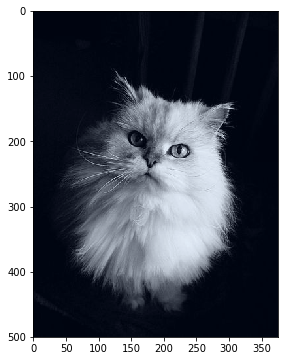

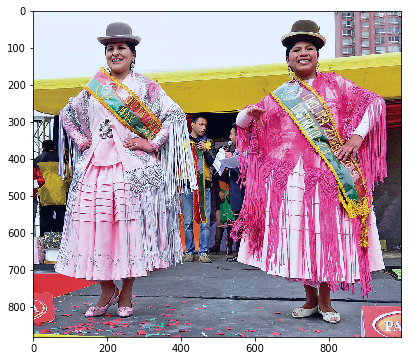

In [4]:
id_example = data_utils.get_example_from_path("../data/imagenet_example_283.jpg", DataConfig.ALEX_NET)
ood_example = data_utils.get_example_from_path("../data/ood_example.jpg", DataConfig.ALEX_NET)

show_normalized(id_example)
show_normalized(ood_example)

#### Random example

Retrieve a random example normalized with the distribution mean and standard deviation, which can also be seen as an out-of-distribution sample.


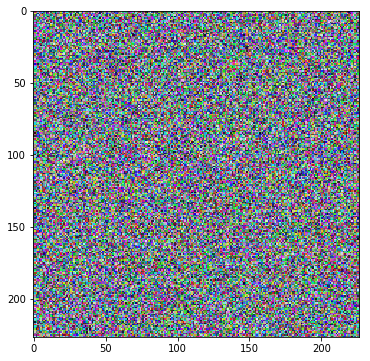

In [5]:
random_example = data_utils.get_random_example(DataConfig.ALEX_NET)

show_normalized(random_example)

### Step 6: Calculate uncertainties

#### In-distribuiton example (correct label: 283)

In [6]:
pred, pred_entropy, mutual_info = ensemble(id_example)

print(f"mean prediction: {pred.argmax()}, class probability: {pred.max()}")
print(f"total predictive entropy: {pred_entropy.sum()}")
print(f"total mutual information: {mutual_info.sum()}")

100%|██████████| 20/20 [00:01<00:00, 12.80it/s]

mean prediction: 283, class probability: 0.4994005262851715
total predictive entropy: 2.8235023021698
total mutual information: 0.214518740773201


#### Out of distribution example

In [7]:
pred, pred_entropy, mutual_info = ensemble(ood_example)

print(f"mean prediction: {pred.argmax()}, class probability: {pred.max()}")
print(f"total predictive entropy: {pred_entropy.sum()}")
print(f"total mutual information: {mutual_info.sum()}")

100%|██████████| 20/20 [00:05<00:00,  3.57it/s]

mean prediction: 614, class probability: 0.015790367498993874
total predictive entropy: 5.820016860961914
total mutual information: 0.14986108243465424


#### Random example

In [8]:
pred, pred_entropy, mutual_info = ensemble(random_example)

print(f"mean prediction: {pred.argmax()}, class probability: {pred.max()}")
print(f"total predictive entropy: {pred_entropy.sum()}")
print(f"total mutual information: {mutual_info.sum()}")

100%|██████████| 20/20 [00:00<00:00, 27.29it/s]

mean prediction: 735, class probability: 0.09608521312475204
total predictive entropy: 4.608819961547852
total mutual information: 0.21713770925998688


## Interpretation of results

We should see that in-distribution examples have a class probability close to 1 and a low uncertainties. Which means, we are predicting with high confidence.

In the OOD and random sample we see that the prediction can be different everytime the ensemble is executed. This is due to the stochasticity of the MC dropout. 

Still, we can observe that the uncertainty is constantly very high, so we predict with low confidence. Whereas, the total predictive entropy (total uncertainty) is high for both, OOD and random example, we see that the mutual information is significantly different. High mutual information idicates that the total uncertainty is mainly due to model uncertainty. Whereas when the mutual information is low, it is an indicator that the total uncertainty is due to data uncertainty.

